# <center>From Concept to Execution: Grok Architecture LLM Analysis<center>
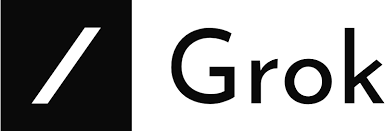

The purpose of this guide is to **`illustrate the specific architecture choices`** implemented in Grok. We will be breaking down the model into its individual components and explaining the reasoning behind each design decision. The Grok model is a large language model that uses a combination of **`Multi-Query Attention (MQA)`** and **`Mixture of Experts (MoE)`** to achieve state-of-the-art performance on a variety of language tasks. The model is trained on a large corpus of text data and is capable of generating coherent and contextually relevant text. In this guide, we will walk through the key components of the Grok model and explain how they work together to achieve superior performance.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import sqrt
from typing import *
import dataclasses
import time as time

# Understanding Grok's Architecture
In this section of the guide, we will delve into the key components of the Grok architecture and explain how they synergize to achieve superior performance. To facilitate a clear understanding of Grok's architecture, we will use an absurdly small size for tensors and other parameters.
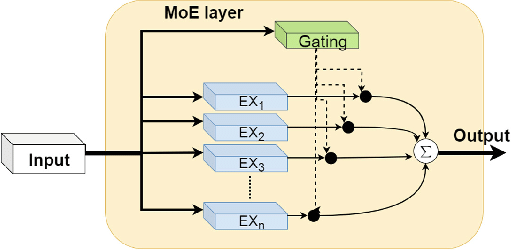

In [ ]:
v = 10 # vocabulary length. Grok's real vocab size is 131,072.
seq_len = 5 # Grok's maximum sequence length is 8192
b = 1 # we'll use a batch size of 1 for simplicity
tokens = torch.randint(v, (b, seq_len)) # randomly generate some token indices

In [ ]:
d=8 # Grok's embedding dimension is 6144
# initializing the embedding layer 
embedding=nn.Embedding(v,d)

In [ ]:
# embedding the tokens indices
x=embedding(tokens)

## Normalization
Prior to normalizing the input, we must scale the embeddings by the square root of their dimension.

In [ ]:
embedding_multiplier_scale = sqrt(d)

x *= embedding_multiplier_scale

## RMS Normalization
The RMSNorm layer normalizes the input tensor by dividing each element by the square root of the mean squared value of the tensor elements. This normalization technique stabilizes the training process and enhances model performance by mitigating issues related to internal covariate shift. 

In [ ]:
# first we square each entry in x and then take the mean of those values across each embedding vector
mean_squared = x.pow(2).mean(dim=-1, keepdim=True)

In [ ]:
# Next, we multiply x by the reciprocal of the square root of the mean squared values. To ensure numerical stability, we add a very small number, 1e-5, in case any entry is zero, preventing division errors.
x_normed=x*torch.rsqrt(mean_squared+1e-5)

In [ ]:
# and finally, we multiply by a learnable scale parameter
# it is now initialized to 1s for simplicity but in training code it will be learned
rms_scale=torch.ones(d)
x_normed*=rms_scale

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, use_scale=True):
        """
        Initialize RMSNorm module.

        Args:
            num_features (int): Number of input features.
            eps (float): Small value added to the denominator for numerical stability.
            use_scale (bool): Whether to use learnable scale parameter.
        """
        super(RMSNorm, self).__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_features)) if use_scale else None

    def forward(self, x):
        """
        Forward pass of the RMSNorm module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            torch.Tensor: Normalized and optionally scaled tensor.
        """
        # Calculate the mean squared value for each feature
        mean_squared = x.pow(2).mean(dim=-1, keepdim=True)

        # Normalize inputs
        x = x * torch.rsqrt(mean_squared + self.eps)

        # Apply scale if it exists
        if self.scale is not None:
            x = x * self.scale

        return x

## Multi-Query Attention (MQA)
The Multi-Query Attention (MQA) mechanism is a key component of the Grok architecture. It allows the model to attend to multiple queries and key-value pairs simultaneously, enabling it to capture complex relationships in the input data. In this section, we will implement the MQA mechanism using PyTorch and explain how it works.

In [ ]:
num_q_heads=2 # Grok has 48 query heads per layer
num_kv_heads=1 # Grok uses 8 key and value heads per layer
assert num_q_heads%num_kv_heads==0 # each q needs to match up to a kv 

# Grok attention head matrices have a size of 128
head_size=4

In [ ]:
# now we'll initialize our self-attention weight matrices
Wq = nn.Linear(d, num_q_heads * head_size, bias=False)
Wk = nn.Linear(d, num_kv_heads * head_size, bias=False)
Wv = nn.Linear(d, num_kv_heads * head_size, bias=False)

# and project x_normed out to get our queries, keys and values
Xq = Wq(x_normed)
Xk = Wk(x_normed)
Xv = Wv(x_normed)

# then reshape them to separate out by head
Xq = Xq.view(b, -1, num_q_heads, head_size)
Xk = Xk.view(b, -1, num_kv_heads, head_size)
Xv = Xv.view(b, -1, num_kv_heads, head_size)

## Rotary Positional Embeddings
Rotary positional embeddings constitute a pivotal element within the Grok architecture, enhancing the model's ability to incorporate positional information from input sequences, thereby improving performance on tasks reliant on sequential reasoning. These embeddings leverage trigonometric functions to dynamically "rotate" the rows in query and key matrices. This rotational mechanism enables the model to discern the relative distance between tokens within a sequence. In the subsequent section, we will implement rotary positional embeddings using PyTorch and elucidate their operational principles.

In [ ]:
assert head_size%2==0
theta=10000# this is a hyperparameter of RoPE that manipulates the frequency of the trig functions. Grok uses 10000

In [ ]:
# Dynamically compute frequency cis based on the input sequence length
exponents = torch.arange(0, head_size, 2)
freqs = 1.0 / (theta ** (exponents.float() / head_size))
t = torch.arange(seq_len)
freqs = torch.outer(t, freqs).float()
freqs_cis = torch.polar(torch.ones_like(freqs), freqs)

# Apply rotary embeddings to our query
Xq = torch.view_as_complex(torch.stack(torch.chunk(Xq.transpose(1, 2).float(), 2, dim=-1), dim=-1))
Xq = torch.view_as_real(Xq * freqs_cis.unsqueeze(0)).type_as(Xq)  
Xq = torch.cat(torch.chunk(Xq, 2, dim=-1), dim=-2)
Xq = Xq.reshape(Xq.shape[0], Xq.shape[1], Xq.shape[2], -1).transpose(1, 2)

# and then to our key
Xk = torch.view_as_complex(torch.stack(torch.chunk(Xk.transpose(1, 2).float(), 2, dim=-1), dim=-1))
Xk = torch.view_as_real(Xk * freqs_cis.unsqueeze(0)).type_as(Xk)  
Xk = torch.cat(torch.chunk(Xk, 2, dim=-1), dim=-2)
Xk = Xk.reshape(Xq.shape[0], Xk.shape[1], Xk.shape[2], -1).transpose(1, 2)


## Attention Calculation
The next step in the Multi-Query Attention mechanism is to calculate the attention logits. This involves taking the dot product of the queries and keys, scaling the logits, and applying a mask to prevent attending to future tokens. In this section, we will implement the attention calculation using PyTorch and explain how it works.

In [ ]:
# If the number of KV heads is different from the number of query heads, adjusts keys and values to match the query heads count.
if num_kv_heads != num_q_heads:
  num_queries_per_kv = num_q_heads // num_kv_heads
  Xk = torch.repeat_interleave(Xk, num_queries_per_kv, dim=2)
  Xv = torch.repeat_interleave(Xv, num_queries_per_kv, dim=2)


In [ ]:
# Transposes Q, K, and V tensors to align them for the batch matrix multiplication in attention calculation.
Xq = Xq.transpose(1, 2)
Xk = Xk.transpose(1, 2)
Xv = Xv.transpose(1, 2)

In [ ]:
# Calculates attention logits by performing a batch matrix multiplication between queries and keys
attn_logits = torch.matmul(Xq, Xk.transpose(2, 3)).type_as(Xv)

# then we scale the logits. In Grok they use 0.08838834764831845 which is the reciprocal of the square root of the head dimension
attn_logits *= sqrt(1/head_size)
attn_logits.shape, attn_logits

In [ ]:
# Here, we will scale and clip our attention logits. The tanh function, a non-linear activation, compresses all entries in `scores` into the range (-1, 1). Subsequently, these scaled values are further adjusted to fall within the range (-30, 30), a chosen arbitrary range. This scaling process serves to regularize and mitigate potential numerical stability issues that could affect the subsequent softmax operation.
max_attn_val = torch.tensor(30.0, dtype = attn_logits.dtype)
attn_logits = max_attn_val * torch.tanh(attn_logits / max_attn_val)

In [ ]:
# Generate a mask tensor of shape [batch_size, num_heads, seq_len, seq_len]. The lower-triangular 1's enable the softmax function to attend to preceding tokens, while 0's ensure that each token does not attend to future tokens.
mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.uint8)).view(1, 1, seq_len, seq_len)
# Expand the mask to cover the batch size and number of heads
mask = mask.expand(b, num_q_heads, -1, -1)  # The mask now has shape [b, num_heads, seq_len, seq_len]

# Convert the mask to a boolean tensor
mask = mask.to(dtype=torch.bool)

# Use a very large negative number for masked positions.
# This large number will be turned into effectively 0 probability by the softmax later
attn_logits = torch.where(mask, attn_logits, torch.tensor(-1e30, device=attn_logits.device, dtype=attn_logits.dtype))

attn_logits.shape, attn_logits

In [ ]:
attn_logits = nn.Softmax(dim=-1)(attn_logits)
attn_logits

In [ ]:
# then matmul by our value projection
output = torch.matmul(attn_logits, Xv)
output.shape, output

In [ ]:
# and reshape to put the sequence length back into place and the outputs of our heads lined up
output = output.transpose(1, 2).contiguous().view(b, seq_len, -1)

In [ ]:
# finally we can initialize and apply our output projection that mixes the information from the heads together
Wout = nn.Linear(num_q_heads * head_size, d, bias=False)
Xout = Wout(output)
Xout.shape, Xout

## First Residual Connection

In [ ]:
post_attn_norm = RMSNorm(d)
x += post_attn_norm(Xout)
x.shape, x

In [ ]:
# then we'll normalize the current state of our residual for use in our MoE later
pre_moe_norm = RMSNorm(d)
x_normed = pre_moe_norm(x)

## Mixture of Experts (MoE)
The Mixture of Experts (MoE) mechanism is another key component of the Grok architecture. It allows the model to combine the outputs of multiple experts to generate the final output. In this section, we will implement the MoE mechanism using PyTorch and explain how it works.

In [ ]:
tot_num_experts = 4 # Grok has 8 experts
chosen_num_experts = 2 # Grok also uses its top 2 experts
widening_factor = 2 # Grok uses a widening factor of roughly 5.33
noise_std = 0.1 # during training we add noise to the logits of the expert router to help prevent one expert from dominating. This would not be done during inference

In [ ]:
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize Expert module.

        Args:
            input_dim (int): Dimensionality of the input.
            hidden_dim (int): Dimensionality of the hidden layer.
            output_dim (int): Dimensionality of the output.
        """
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim * 2, bias=False)  # Double the output for gating
        self.layer2 = nn.Linear(hidden_dim, output_dim, bias=False)  # Output layer remains the same

    def forward(self, x):
        """
        Forward pass of the Expert module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the Expert network.
        """
        # Split the output of the first layer for gating
        x, gate = self.layer1(x).chunk(2, dim=-1)

        # Apply GeLU to the gate, and then multiply element-wise
        x = F.gelu(gate) * x

        # Pass through the second linear layer
        x = self.layer2(x)

        return x


In [ ]:
# Instantiate a List of 4 Expert modules
experts = nn.ModuleList([Expert(input_dim = d, hidden_dim = d * widening_factor, output_dim = d) for _ in range(tot_num_experts)])

experts[0].layer1.weight.shape, experts[0].layer1.weight, experts[0].layer2.weight.shape, experts[0].layer2.weight

## Router
The Router is a key component of the Grok architecture. It is responsible for routing the input data to the appropriate expert based on the input features. In this section, we will implement the Router using PyTorch and explain how it works.

In [ ]:
# now we define the router that chooses which experts get used, which is just a simple linear layer with output size = tot_num_experts
router = nn.Linear(d, tot_num_experts, bias=False)
router.weight.shape, router.weight

In [ ]:
x_routed = router(x_normed)
x_routed.shape, x_routed

In [ ]:
# if we are training then we'll also add in some gaussian noise to help encourage the model to use all experts
# without this, the logits of one model might quickly decay to constantly outputting 0
x_routed = x_routed + torch.randn_like(x_routed) * noise_std # the choice of noise_st=0.1 is a hyperparameter that would need to be tuned
x_routed.shape, x_routed

In [ ]:
# here we softmax to get the model's probabilities denoting which experts it things we should use
routing_probs = F.softmax(x_routed, dim=-1)
routing_probs.shape, routing_probs

In [ ]:
routing_probs_for_loss = routing_probs

In [ ]:
expert_gate, expert_indices = torch.topk(routing_probs, k = chosen_num_experts, sorted=True)
expert_gate, expert_indices

## MoE Output Calculation

In [ ]:
# Reshape x_normed to (b*seq_len, d) for batched processing
x_reshaped = x_normed.view(-1, d)
x_reshaped.shape

In [ ]:
# Apply all experts to the input
expert_outputs = [expert(x_reshaped) for expert in experts]
expert_outputs[0].shape 

In [ ]:
expert_outputs_concat = torch.cat(expert_outputs, dim=0)
expert_outputs_concat.shape

In [ ]:
# then reshape for masking
expert_outputs_reshaped = expert_outputs_concat.view(b, seq_len, tot_num_experts, d)
expert_outputs_reshaped.shape

## Using router to the output of our experts

In [ ]:
# here we turn out expert_indices into multi-hot vectors to make them compatible with our module list of experts
multi_hot_indices = torch.zeros(b, seq_len, tot_num_experts)
multi_hot_indices.scatter_(2, expert_indices, 1)
multi_hot_indices.shape, multi_hot_indices

In [ ]:
# Apply the multi-hot mask (first expand dimensions for broadcasting)
multi_hot_expanded = multi_hot_indices.unsqueeze(-1).expand_as(expert_outputs_reshaped)
output_masked = expert_outputs_reshaped * multi_hot_expanded.float()
output_masked.shape, output_masked

In [ ]:
# then weight our experts' outputs by the softmax values (which we first must broadcast to the right shape)
# this step is important because it allows gradients to backprop through the router, meaning the model can learn which experts to use
routing_probs = routing_probs.unsqueeze(-1).expand_as(output_masked)
MoE_output = output_masked * routing_probs
MoE_output.shape, MoE_output

In [ ]:
# and finally sum across the chosen experts
MoE_output = MoE_output.sum(dim=2)
MoE_output.shape, MoE_output

## Final Residual Connection

In [ ]:
post_moe_norm = RMSNorm(d)
x += post_moe_norm(MoE_output)

## Getting the Output

In [ ]:
# Multiply x by the transpose of the embedding weights to get our final output logits
logits = x @ embedding.weight.t()
logits.shape, logits

In [ ]:
# softmax the logits
probs = F.softmax(logits, dim=-1)
probs

In [ ]:
indices = torch.argmax(probs, dim=-1)
indices

## Loss Calculation

In [ ]:
# create some random target indices to train on
target_token_indices = torch.randint(0, v, indices.shape)

# initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# reshape logits to be compatible and calculate loss
CEloss = loss_fn(logits.view(1,v,seq_len), target_token_indices)
CEloss

The part of note here is our expert diversity loss which is designed to encourage the model to use all of its experts roughly the same amount rather than over-relying on a small number of them. If you let the model over-rely on one or two experts, especially early in training, then what'll end up happening is it'll stick with the first ones that started to show some promise, the router will learn to only route to those two, and next thing you know you've got a bunch of untrained and unutilized experts, kinda defeating the point of MoE. To combat this, we take the probabilities outputted by the router, calculate the variance between experts in each batch, and encourage that variance to go down.

In [ ]:
# first we sum across the sequences in the batch since during inference we want every single sequence the model runs on to use all experts
expert_usage = routing_probs_for_loss.sum(dim=0)
expert_usage.shape, expert_usage

In [ ]:
# Compute the mean so that we can later compute the variance
usage_mean = expert_usage.mean()
usage_mean

In [ ]:
# and now variance which is just squared distance from the mean
expert_variance = ((expert_usage - usage_mean) ** 2).mean()
expert_variance
# by encouraging the model to minimize this, it'll be forced to use all experts with roughly the same frequency

In [ ]:
lambadada = 500 # this is a hyperparameter that would need to be tuned

In [ ]:
loss = CEloss + lambadada * expert_variance
loss

# Putting it All Together

In [ ]:
def apply_rotary_emb(x: torch.Tensor, dim: int, theta: float = 10000.0) -> torch.Tensor:
    """
    Applies rotary embeddings to the input tensor.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, seq_len, dim).
        dim (int): Dimensionality of the input tensor.
        theta (float): Frequency scaling factor for rotary embeddings.

    Returns:
        torch.Tensor: Output tensor after applying rotary embeddings.
    """
    # Get sequence length
    seq_len = x.size(1)
    device = x.device

    # Dynamically compute frequency cis based on the input sequence length
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, device=device).float() / dim))
    t = torch.arange(seq_len, device=device)
    freqs = torch.outer(t, freqs).float()
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64

    # Apply rotary embeddings to the input tensor
    x_ = torch.view_as_complex(torch.stack(torch.chunk(x.transpose(1, 2).float(), 2, dim=-1), dim=-1))
    x_out = torch.view_as_real(x_ * freqs_cis.unsqueeze(0)).type_as(x)  # Ensure batch dimension is handled
    x_out = torch.cat(torch.chunk(x_out, 2, dim=-1), dim=-2)
    x_out = x_out.reshape(x_out.shape[0], x_out.shape[1], x_out.shape[2], -1).transpose(1, 2)

    return x_out


In [ ]:
class MQA(nn.Module):
    """
    Implements Multi-Query Attention which supports a distinct number of attention heads for queries and key-values (KV).
    In the case where the same number of queries and key-values are used, this implementation is equivalent to regular Multi-Head Attention.
    """
    def __init__(self, config):
        """
        Initializes the MQA module.

        Args:
            config: Configuration object containing model hyperparameters.
        """
        super().__init__()

        self.num_heads = config.num_attention_heads
        self.num_kv_heads = config.num_key_value_heads
        assert self.num_heads % self.num_kv_heads == 0
        self.num_queries_per_kv = self.num_heads // self.num_kv_heads

        self.hidden_size = config.hidden_size
        self.head_dim = config.head_dim
        self.theta = config.rope_theta

        self.q_size = self.num_heads * self.head_dim
        self.kv_size = self.num_kv_heads * self.head_dim

        # Projection layers
        self.qkv_proj = nn.Linear(self.hidden_size, (self.num_heads + 2 * self.num_kv_heads) * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)

        # Mask tensor for attention
        self.mask = torch.tril(torch.ones((config.max_position_embeddings, config.max_position_embeddings),
                                     dtype=torch.uint8)).view(1, 1, config.max_position_embeddings, config.max_position_embeddings).to(dtype=torch.bool)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MQA module.

        Args:
            hidden_states (torch.Tensor): Input tensor of shape (batch_size, seq_len, hidden_size).

        Returns:
            torch.Tensor: Output tensor after Multi-Query Attention mechanism.
        """
        hidden_states_shape = hidden_states.shape
        assert len(hidden_states_shape) == 3
        batch_size, input_len, _ = hidden_states_shape

        # Linear projection to retrieve q, k, v projections
        qkv = self.qkv_proj(hidden_states)
        xq, xk, xv = qkv.split([self.q_size, self.kv_size, self.kv_size], dim=-1)

        # Reshape to separate heads and align dimensions for attention operations
        xq = xq.view(batch_size, -1, self.num_heads, self.head_dim)
        xk = xk.view(batch_size, -1, self.num_kv_heads, self.head_dim)
        xv = xv.view(batch_size, -1, self.num_kv_heads, self.head_dim)

        # Apply rotary positional embeddings to queries and keys
        xq = apply_rotary_emb(xq, self.head_dim, self.theta)
        xk = apply_rotary_emb(xk, self.head_dim, self.theta)

        # Adjust keys and values if the number of KV heads differs from the number of query heads
        if self.num_kv_heads != self.num_heads:
            xk = torch.repeat_interleave(xk, self.num_queries_per_kv, dim=2)
            xv = torch.repeat_interleave(xv, self.num_queries_per_kv, dim=2)

        # Transpose to align for batch matrix multiplication in attention calculation
        q = xq.transpose(1, 2)
        k = xk.transpose(1, 2)
        v = xv.transpose(1, 2)

        # Calculate attention logits
        logits = torch.matmul(q, k.transpose(2, 3))

        # Scale logits by the square root of head dimension
        logits *=  0.08838834764831845

        # Apply scaling and clipping using tanh to stabilize softmax
        max_attn_val = torch.tensor(30.0, dtype=logits.dtype, device=logits.device)
        logits = max_attn_val * torch.tanh(logits / max_attn_val)

        # Apply lower-triangular mask to attention logits
        logits = torch.where(self.mask[..., :input_len, :input_len].expand_as(logits), logits, torch.tensor(-1e30, device=logits.device, dtype=logits.dtype))

        # Apply softmax to obtain attention scores
        scores = F.softmax(logits, dim=-1)

        # Weighted sum of values based on attention scores
        output = torch.matmul(scores, v)

        # Reshape attention output to combine heads back into hidden dimension
        output = output.transpose(1, 2).contiguous().view(batch_size, input_len, -1)

        # Final linear projection to map back to hidden size dimension
        output = self.o_proj(output)

        return output


In [ ]:
class Expert(nn.Module):
    def __init__(self, model_dim, hidden_dim):
        """
        Initialize an Expert module.

        Args:
            model_dim (int): Dimensionality of the input to the expert.
            hidden_dim (int): Dimensionality of the hidden layer within the expert.
        """
        super().__init__()
        self.layer1 = nn.Linear(model_dim, hidden_dim * 2, bias=False)  # Double the output for gating
        self.layer2 = nn.Linear(hidden_dim, model_dim, bias=False)  # Output layer remains the same

    def forward(self, x):
        """
        Forward pass of the Expert module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the Expert network.
        """
        # Split the output of the first layer for gating
        x, gate = self.layer1(x).chunk(2, dim=-1)

        # Apply GeLU to the gate, and then multiply element-wise
        x = F.gelu(gate) * x
        x = self.layer2(x)

        return x


class Router(nn.Module):
    def __init__(self, input_size, tot_num_experts, noise_std: float = 0.1):
        """
        Initialize a Router module.

        Args:
            input_size (int): Dimensionality of the input to the router.
            tot_num_experts (int): Total number of experts in the mixture.
            noise_std (float): Standard deviation of Gaussian noise added during training for exploration.
        """
        super().__init__()
        self.tot_num_experts = tot_num_experts
        self.router_weights = nn.Linear(input_size, tot_num_experts, bias=False)
        self.noise_std = noise_std

    def forward(self, inputs, training: bool = False):
        """
        Forward pass of the Router module.

        Args:
            inputs (torch.Tensor): Input tensor.
            training (bool): Whether the model is in training mode or not.

        Returns:
            torch.Tensor: Routing probabilities over the experts.
        """
        routing_logits = self.router_weights(inputs)
        if training:
            routing_logits = routing_logits + torch.randn_like(routing_logits) * self.noise_std
        routing_probs = F.softmax(routing_logits, dim=-1)
        return routing_probs


class MoELayer(nn.Module):
    def __init__(self, model_dim, expert_hidden_dim, tot_num_experts, chosen_num_experts, noise_std):
        """
        Initialize a Mixture of Experts (MoE) Layer module.

        Args:
            model_dim (int): Dimensionality of the input to the MoE layer.
            expert_hidden_dim (int): Dimensionality of the hidden layer within each expert.
            tot_num_experts (int): Total number of experts in the mixture.
            chosen_num_experts (int): Number of experts to use for each input.
            noise_std (float): Standard deviation of Gaussian noise added during training for exploration.
        """
        super().__init__()
        self.model_dim = model_dim
        self.tot_num_experts = tot_num_experts
        self.chosen_num_experts = chosen_num_experts
        self.experts = nn.ModuleList([Expert(model_dim, expert_hidden_dim) for _ in range(tot_num_experts)])
        self.router = Router(model_dim, tot_num_experts, noise_std)

    def forward(self, inputs, training: bool = False):
        """
        Forward pass of the MoE Layer module.

        Args:
            inputs (torch.Tensor): Input tensor.
            training (bool): Whether the model is in training mode or not.

        Returns:
            torch.Tensor: MoE output tensor.
            torch.Tensor: Routing probabilities over the experts.
        """
        b, seq_len, _ = inputs.shape

        # Get the output of all the experts
        expert_outputs = [expert(inputs.view(-1, self.model_dim)) for expert in self.experts]
        expert_outputs = torch.cat(expert_outputs, dim=0).view(b, seq_len, self.tot_num_experts, self.model_dim)

        # Get the output of the router and create the expert mask
        routing_probs = F.softmax(self.router(inputs), dim=-1)
        with torch.no_grad():
            expert_indices = torch.topk(routing_probs, k=self.chosen_num_experts, sorted=True).indices
            multi_hot_indices = torch.zeros(b, seq_len, self.tot_num_experts, device=inputs.device)
            multi_hot_indices = multi_hot_indices.scatter(2, expert_indices, 1)

        # Apply the multi-hot mask (first expand dimensions for broadcasting)
        multi_hot_expanded = multi_hot_indices.unsqueeze(-1).expand_as(expert_outputs)
        output_masked = expert_outputs * multi_hot_expanded.float()

        # Weight our experts' outputs by the softmax values (which we first must broadcast to the right shape) and sum them
        routing_probs_expanded = routing_probs.unsqueeze(-1).expand_as(output_masked)
        MoE_output = (output_masked * routing_probs_expanded).sum(dim=2)

        return MoE_output, routing_probs  # Also output routing_probs to be used in the loss function later

In [ ]:
class DecoderLayer(nn.Module):
    """
    A decoder layer that integrates the Attention mechanism and MoE. It includes
    normalization steps both before and after the MQA and MoE but never actually normalizes the residual connection.
    """

    def __init__(self, config):
        """
        Initializes a DecoderLayer.

        Args:
            config (object): Configuration object containing model parameters.
        """
        super().__init__()

        # Multi-Query Attention (MQA) module
        self.mqa = MQA(config)

        # Mixture of Experts (MoE) layer
        self.moe = MoELayer(
            model_dim=config.hidden_size,
            expert_hidden_dim=config.hidden_size * config.embedding_multiplier_scale,
            tot_num_experts=config.tot_num_experts,
            chosen_num_experts=config.chosen_num_experts,
            noise_std=config.noise_std
        )

        # RMS normalization layers
        self.pre_mqa_norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps, use_scale=config.use_scale)
        self.post_mqa_norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps, use_scale=config.use_scale)
        self.pre_moe_norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps, use_scale=config.use_scale)
        self.post_moe_norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps, use_scale=config.use_scale)

        # Dropout layer
        self.drop = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor, training: bool = False) -> torch.Tensor:
        """
        Forward pass of the DecoderLayer.

        Args:
            x (torch.Tensor): Input tensor.
            training (bool): Whether the model is in training mode or not.

        Returns:
            torch.Tensor: Output tensor after processing through MQA and MoE.
            torch.Tensor: Routing probabilities from the MoE layer (only returned during training).
        """
        # Apply MQA with normalization before and after
        if training:
            x = x + self.drop(self.post_mqa_norm(self.mqa(self.pre_mqa_norm(x))))
            moe_out, routing_probs = self.moe(self.pre_moe_norm(x), training)
            x = x + self.drop(self.post_moe_norm(moe_out))
        else:
            x = x + self.post_mqa_norm(self.mqa(self.pre_mqa_norm(x)))
            moe_out, routing_probs = self.moe(self.pre_moe_norm(x), training)
            x = x + self.post_moe_norm(moe_out)

        return x, routing_probs


In [ ]:
class minGrok(nn.Module):
    """
    minGrok model implementation that combines Multi-Query Attention (MQA) and Mixture of Experts (MoE)
    for language modeling tasks.
    """

    def __init__(self, config, tokenizer):
        """
        Initializes the minGrok model.

        Args:
            config (object): Configuration object containing model parameters.
            tokenizer (object): Tokenizer object for tokenizing text inputs.
        """
        super().__init__()
        self.config = config

        # Ensure hidden_size is cleanly divisible by num_attention_heads for proper splitting and combining
        assert config.hidden_size % config.num_attention_heads == 0

        self.max_seq_len = config.max_position_embeddings
        self.head_dim = config.head_dim
        self.vocab_size = config.vocab_size
        self.tokenizer = tokenizer

        # Embedding matrix for converting tokens to the initial residual state and logits
        self.embedder = nn.Embedding(self.vocab_size, config.hidden_size)

        # Initialize DecoderLayers based on the number specified in config
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.num_layers)])

        # Final RMS normalization layer to stabilize the output
        self.final_norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        # CrossEntropyLoss criterion for training
        self.criterion = nn.CrossEntropyLoss()

        # Weighting parameter for the MoE loss
        self.lambadada = config.lambadada

    def calc_moe_loss(self, routing_probs_list):
        """
        Calculates the Mixture of Experts (MoE) loss based on routing probabilities.

        Args:
            routing_probs_list (list): List of routing probabilities from each layer.

        Returns:
            torch.Tensor: Cumulative variance-based MoE loss.
        """
        # Concatenate routing probabilities along a new dimension
        all_routing_probs = torch.cat([x.unsqueeze(0) for x in routing_probs_list], dim=0)

        # Calculate expert usage across batch and sequence dimensions
        expert_usage = all_routing_probs.sum(dim=(1, 2))

        # Calculate mean and variance across experts and layers
        usage_mean = expert_usage.mean(dim=0)
        expert_variance = ((expert_usage - usage_mean) ** 2).mean(dim=0)

        # Sum variance across experts
        cum_var = expert_variance.sum()

        return cum_var

    def forward(
        self,
        input_token_ids: torch.Tensor,
        target_token_ids: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Forward pass of the minGrok model.

        Args:
            input_token_ids (torch.Tensor): Input token indices of shape (batch_size, input_seq_len).
            target_token_ids (torch.Tensor, optional): Target token indices for training. Default is None.

        Returns:
            torch.Tensor: Logits tensor of shape (batch_size, input_seq_len, vocab_size).
            torch.Tensor: Loss value if in training mode, else None.
        """
        training = False if target_token_ids is None else True

        # Convert input tokens to initial residual state using the embedding matrix
        x = self.embedder(input_token_ids) * self.config.hidden_size ** 0.5  # Grok normalizes embedding by sqrt(hidden_size)

        routing_probs_list = []  # List to store routing probabilities of each layer
        # Process input through each DecoderLayer
        for layer in self.layers:
            x, routing_probs = layer(x, training)
            if training:
                routing_probs_list.append(routing_probs)

        # Apply final normalization to the output of the last DecoderLayer
        x = self.final_norm(x)

        # Get the weights of the embedding matrix for use as the output layer
        embedder_weight = self.embedder.weight

        # Calculate logits by matrix multiplication of final output and embedding weights
        logits = torch.matmul(x, embedder_weight.t())

        if training:
            batch_size, input_len, vocab_size = logits.shape

            # Flatten logits and target_token_ids for CrossEntropyLoss
            CEloss = self.criterion(logits.view(batch_size * input_len, vocab_size),
                                    target_token_ids.view(batch_size * input_len))

            # Calculate MoE loss to encourage usage of all experts
            MoEloss = self.calc_moe_loss(routing_probs_list)

            # Combined loss with weighting parameter lambda
            loss = CEloss + MoEloss * self.lambadada
        else:
            loss = None

        return logits, loss

    @torch.no_grad()
    def Sampler(
        self,
        logits: torch.Tensor,
        temperature: float,
        top_p: float,
        top_k: int,
    ) -> torch.Tensor:
        """
        Generates token predictions from logits using sampling techniques.

        Args:
            logits (torch.Tensor): Logits tensor of shape (batch_size, vocab_size).
            temperature (float): Temperature scaling factor for softmax.
            top_p (float): Top-p (nucleus) sampling threshold.
            top_k (int): Top-k sampling threshold.

        Returns:
            torch.Tensor: Predicted token indices of shape (batch_size,).
        """
        logits = logits[:, -1, :]  # Select logits for the last token

        # Apply temperature scaling to logits
        logits.div_(temperature)

        # Calculate softmax probabilities
        probs = torch.softmax(logits, dim=-1, dtype=torch.float)

        # Sort probabilities for top-p and top-k sampling
        probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)

        # Apply top-p sampling mask
        probs_sum = torch.cumsum(probs_sort, dim=-1)
        top_ps_mask = (probs_sum - probs_sort) > top_p
        probs_sort = torch.where(top_ps_mask, 0, probs_sort)

        # Apply top-k sampling mask
        top_ks_mask = torch.arange(probs_idx.shape[-1], device=probs_idx.device)
        top_ks_mask = top_ks_mask.expand(probs_idx.shape[0], -1) >= top_k
        probs_sort = torch.where(top_ks_mask, 0, probs_sort)

        # Re-normalize probabilities
        probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))

        # Rearrange probabilities back to original order
        probs = torch.gather(probs_sort, dim=-1, index=torch.argsort(probs_idx, dim=-1))

        # Sample from the probability distribution
        next_token_id = torch.multinomial(probs, num_samples=1)

        return next_token_id

    def generate(
        self,
        prompt: str,
        output_len: int = 100,
        temperature: float = 0.95,
        top_p: float = 1.0,
        top_k: int = 65,
    ) -> str:
        """
        Generates text based on a prompt using the minGrok model.

        Args:
            prompt (str): Input prompt for text generation.
            output_len (int): Length of the generated text in tokens.
            temperature (float): Temperature scaling factor for sampling.
            top_p (float): Top-p (nucleus) sampling threshold.
            top_k (int): Top-k sampling threshold.

        Returns:
            str: Generated text based on the prompt.
        """
        tokens = self.tokenizer.encode(prompt)  # Encode input prompt into token indices
        tokens = torch.tensor(tokens, device=self.config.device).unsqueeze(0)  # Convert to tensor

        # Check that generated output length does not exceed maximum allowed sequence length
        assert len(tokens) + output_len <= self.config.max_position_embeddings

        for _ in range(output_len):
            logits, _ = self(tokens[:, :self.max_seq_len])  # Get logits from model

            next_token = self.Sampler(
                logits=logits, 
                temperature=temperature,
                top_p=top_p,
                top_k=top_k
            )

            # Append predicted token to the sequence
            tokens = torch.cat((tokens, next_token), dim=1)

        # Decode token indices to text
        output = self.tokenizer.decode(tokens.squeeze(0).tolist())

        return output


In [ ]:
with open('/kaggle/input/minigrok-training/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# the first 200 characters. It's just one continuous text document with all of the works of shakespeare back-to-back
print(text[:200])

# here are all the unique characters that occur in this text and how many there are
chars = sorted(list(set(text)))
v = len(chars)
print(chars)
print(v)

In [ ]:
from typing import List

class CharacterTokenizer:
    def __init__(self, chars: List[str]):
        """
        Initialize the CharacterTokenizer with a list of characters.

        Args:
            chars (List[str]): List of characters to create mappings from and to.
        """
        # Create a dictionary mapping characters to indices
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        
        # Create a dictionary mapping indices back to characters
        self.itos = {i: ch for i, ch in enumerate(chars)}

    def encode(self, s: str) -> List[int]:
        """
        Convert a string into a list of character IDs.

        Args:
            s (str): Input string to encode.

        Returns:
            List[int]: List of character IDs.
        """
        # Use dictionary 'stoi' to convert each character in 's' to its corresponding ID
        return [self.stoi.get(c) for c in s]

    def decode(self, t: List[int]) -> str:
        """
        Convert a list of character IDs back into a string.

        Args:
            t (List[int]): List of character IDs to decode.

        Returns:
            str: Decoded string.
        """
        # Use dictionary 'itos' to convert each ID in 't' back to its corresponding character
        return ''.join([self.itos.get(i) for i in t])

tokennizer = CharacterTokenizer(chars)
# Encoding text
encoded_text = tokennizer.encode("JULIET:\nO Romeo, Romeo! wherefore art thou Romeo?")
print("Encoded:", encoded_text)

# Decoding back
decoded_text = tokennizer.decode(encoded_text)
print("Decoded:", decoded_text)

In [ ]:
@dataclasses.dataclass
class Config:
    """
    Configuration class defining hyperparameters and settings for the minGrok model.
    """

    # Vocabulary size, typically the number of unique tokens in the dataset
    vocab_size: int = 65

    # Maximum sequence length the model might encounter
    max_position_embeddings: int = 256  # In Grok it's 8,192

    # Number of layers in the model
    num_layers: int = 4  # In Grok it's 64

    # Number of attention heads used in the attention layers of the model
    num_attention_heads: int = 4  # In Grok it's 48

    # Number of key-value heads for implementing attention
    num_key_value_heads: int = 1  # In Grok it's 8

    # Hidden size of the model, also known as the embedding dimension
    hidden_size: int = 96  # In Grok it's 6,144

    # Multiplier scale for the embedding dimension in MoE layers
    embedding_multiplier_scale: int = 2  # In Grok it's roughly 5.33

    # Total number of experts in the MoE layers
    tot_num_experts: int = 4  # In Grok it's 8

    # Number of active experts per token in the MoE layers
    chosen_num_experts: int = 2  # In Grok it's also 2

    # Standard deviation of noise injected into the router during training
    noise_std = 0.1  # Actual value for Grok has not been shared

    # Weighting factor for the loss encouraging all experts to be used
    lambadada = 10  # Actual value for Grok has not been shared

    # Number of dimensions per attention head
    head_dim: int = 24  # In Grok it's 128

    # Epsilon value used by the RMS normalization layers to prevent division by zero
    rms_norm_eps: float = 1e-5  # Promotes numerical stability

    # Scaling factor that determines frequencies for rotary positional encodings
    rope_theta = 100.0  # In Grok and many models it's typically 10,000

    # Whether to use a linear layer after normalization
    use_scale: bool = True  # Same in Grok

    # Device to run the model on (CPU or CUDA)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Dropout rate to use during training
    dropout = 0.05


config = Config()

In [ ]:
data = torch.tensor(tokennizer.encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be our training dataset, the rest for validation
train_data = data[:n]
val_data = data[n:]

In [ ]:
# data loading for training which generates a small batch of data of inputs x and targets y
def get_batch(split, batch_size):
    # whether we grab from our training or validation dataset
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - config.max_position_embeddings, (batch_size,))
    x = torch.stack([data[i:i+config.max_position_embeddings] for i in ix])
    y = torch.stack([data[i+1:i+config.max_position_embeddings+1] for i in ix])
    x, y = x.to(config.device), y.to(config.device)
    return x, y

In [ ]:
@torch.no_grad()
def estimate_loss(model, batch_size, eval_iters = 10): # to periodically estimate loss during the training loop
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out

In [ ]:
model = minGrok(config, tokennizer).to(config.device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

print(model)

# Training the Model

In [ ]:
# set up the optimizer
learning_rate = 3e-4
weight_decay = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

max_iters = 5 #I used 100000 for the full training

eval_interval = 2 

# batch size to use
batch_size = 16 # I used 64 for the full training


In [ ]:
start_time = time.time()


for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_batch('train', batch_size)

    # train
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss(model, batch_size)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")


# Generating Text

In [ ]:
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou " # the classic line
max_useable_output_len = config.max_position_embeddings - len(input_str)
output = model.generate(input_str, output_len = max_useable_output_len)
print(output)

We will not get any output as we have not trained the model for enough iterations. The model needs to be trained for a longer duration to generate meaningful text. If you want to train the model for a longer duration, you can set the `max_iters` variable to a higher value.

If you inspect the output carefully the output mostly consists of space 😅.

# Loading my own trained model
I had trained the model for 200000 iterations and saved the model. I will load the model and generate text using the model. It is not perfect but it still captures the essence of the text and some patterns in the text.

In [ ]:
model = minGrok(config, tokennizer)
model.load_state_dict(torch.load('/kaggle/input/minigrok/pytorch/max_iter200000/1/miniGrok200000', map_location=torch.device('cpu')))

In [ ]:
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou " # the classic line
max_useable_output_len = config.max_position_embeddings - len(input_str)
output = model.generate(input_str, output_len = max_useable_output_len)
print(output)

# Conclusion
We successfully implemented the minGrok model using PyTorch. We trained the model on a small dataset and generated text using the trained model. The model generated text that captures the essence of the text and some patterns in the text. The model can be further trained on a larger dataset to generate more meaningful text.

The text generated is not good but it still captures some patterns in the text. The model needs to be trained for a longer duration on a larger dataset to generate meaningful text. But I think this much traning was enough to show the implementation of the model.